# Importar Bibliotecas Necessárias
Importe as bibliotecas necessárias, incluindo pandas, numpy, scikit-learn e matplotlib.

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Carregar e Explorar o Conjunto de Dados

Carregar o dataset e visualizar o *head*, além de transformar dados categóricos em numéricos via **One-Hot Encoding**

In [31]:
df = pd.read_csv('Modelo\\Data.csv')

df.head()

,QT_VOTOS,VR_DESPESA_CONTRATADA
0,1125,213127.50
1,27393,3016571.30
2,771,99998.00
3,242100,4077998.59
4,103265,2462596.06


In [32]:
scaler = MinMaxScaler()
df[['VR_DESPESA_CONTRATADA', 'QT_VOTOS']] = scaler.fit_transform(df[['VR_DESPESA_CONTRATADA', 'QT_VOTOS']])

df.head()

,QT_VOTOS,VR_DESPESA_CONTRATADA
0,0.000021,0.005654
1,0.001145,0.080912
2,0.000005,0.002617
3,0.010335,0.109405
4,0.004393,0.066040


In [33]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

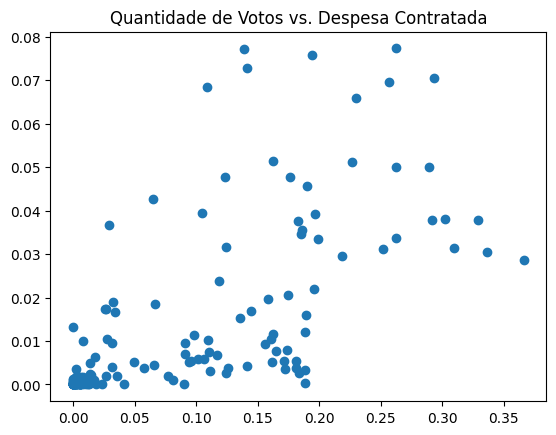

In [34]:
plt.scatter(x='VR_DESPESA_CONTRATADA', y='QT_VOTOS', data=df)
plt.title('Quantidade de Votos vs. Despesa Contratada')
plt.show()

# Dividir os Dados em Conjuntos de Treinamento e Teste
Divida o conjunto de dados em conjuntos de treinamento e teste usando train_test_split do scikit-learn.

In [35]:
X = df.drop('QT_VOTOS', axis=1)
y = df['QT_VOTOS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((141, 1), (36, 1), (141,), (36,))

# Treinar o Modelo de Regressão Linear
Treine um modelo de Regressão Linear usando os dados de treinamento via k_folds e após, ajustar o fit com todos os dados

In [36]:
model = LinearRegression()

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores = np.sqrt(-cv_scores)

print(f"Cross Validation RMSE Scores: {cv_scores}")
print(f"Mean Cross Validation RMSE: {cv_scores.mean()}")
print(f"Standard Deviation of Cross Validation RMSE: {cv_scores.std()}")

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)

print(f"Mean Squared Error on Training Data: {mse_train}")

Cross Validation RMSE Scores: [0.00951957 0.01589572 0.01470979 0.01727914 0.0098083 ]
Mean Cross Validation RMSE: 0.013442504557697191
Standard Deviation of Cross Validation RMSE: 0.0031918935605600024
Mean Squared Error on Training Data: 0.0001813597297075486


In [37]:
y_test_pred = model.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Mean Squared Error on Testing Data (RMSE): {mse_test}")
print(f"Mean Absolute Error on Testing Data (MAE): {mae_test}")
print(f"R-squared on Testing Data (R²): {r2_test}")


Mean Squared Error on Testing Data (RMSE): 0.00017064899230990408
Mean Absolute Error on Testing Data (MAE): 0.006947162404934381
R-squared on Testing Data (R²): 0.509639997315932


# Validar o Modelo

Validaremos o modelos utilizando as medidas padrões.

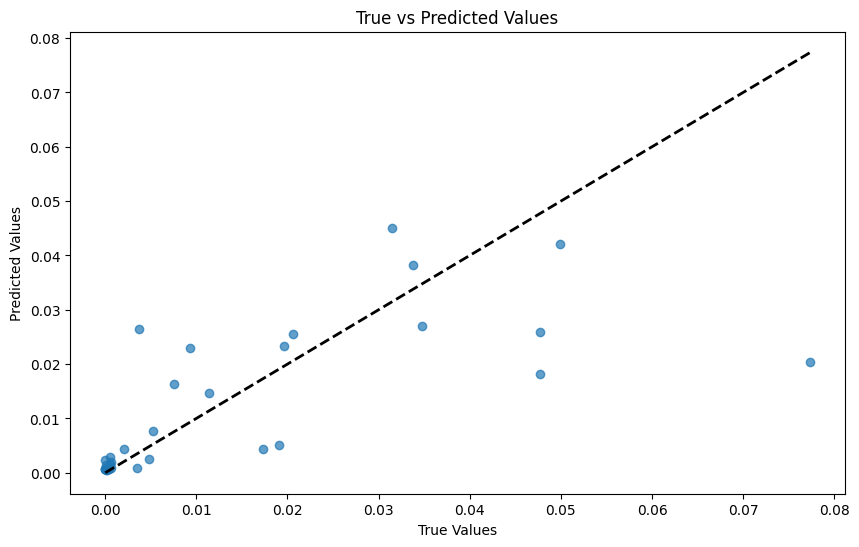

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

# Make Predictions
Use the trained model to make predictions on new data and visualize the results.

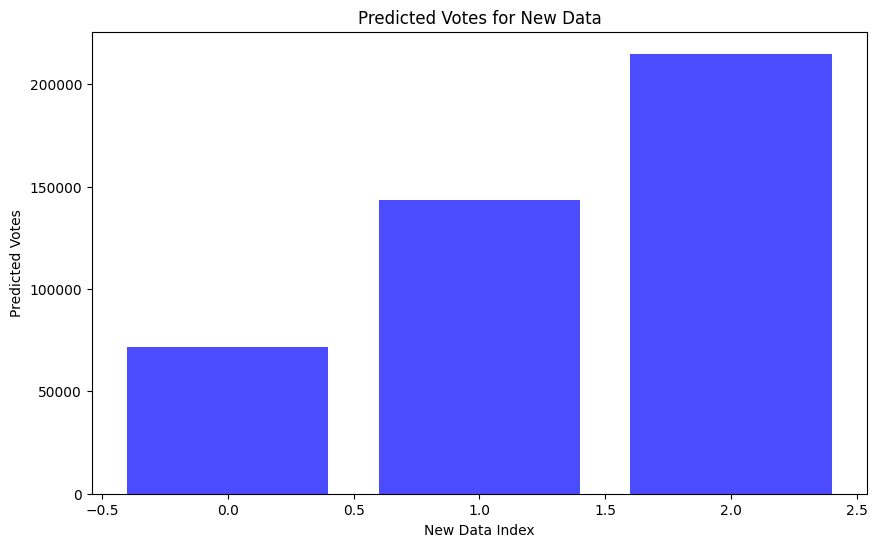

In [39]:
new_data = pd.DataFrame({
    'VR_DESPESA_CONTRATADA': [500000, 1000000, 1500000],
})

new_predictions = model.predict(new_data)

new_data['Predicted_QT_VOTOS'] = new_predictions
new_data

plt.figure(figsize=(10, 6))
plt.bar(new_data.index, new_data['Predicted_QT_VOTOS'], color='blue', alpha=0.7)
plt.xlabel('New Data Index')
plt.ylabel('Predicted Votes')
plt.title('Predicted Votes for New Data')
plt.show()